In [8]:
import argparse
import logging
import sys
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import torchvision
from PIL import Image
from torchvision import transforms
import torchvision.transforms as transforms
from utils.dice_score import dice_loss
from evaluate import evaluate
from unet_model import UNet
from wholeslidedata.iterators import create_batch_iterator
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import init_plot, plot_batch, show_plot
from shapely.prepared import prep
import cv2

In [9]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
from utils.dice_score import dice_loss
from evaluate import evaluate
from unet_model import UNet

cuda


In [10]:
net = UNet(n_channels=3, n_classes=2, bilinear=True)
logging.info(f'Using device {device}')
net.to(device=device)
net.load_state_dict(torch.load('/code/MIP_G3/BulkTumor-UNET/pathology-whole-slide-data/checkpoints/weights_30.pth', map_location=device))
logging.info('Model loaded!')

In [11]:
def mask_to_image(mask: np.ndarray):
    if mask.ndim == 2:
        return Image.fromarray((mask * 255).astype(np.uint8))
    elif mask.ndim == 3:
        return Image.fromarray((np.argmax(mask, axis=0) * 255 / mask.shape[0]).astype(np.uint8))

In [12]:
criterion = nn.CrossEntropyLoss()
def dice_loss(output, target):

    eps = 0.0001

    intersection = output * target
    numerator = 2 * intersection.sum(0).sum(1).sum(1)
    denominator = output + target
    denominator = denominator.sum(0).sum(1).sum(1) + eps
    loss_per_channel = (1 - (numerator / denominator))

    return loss_per_channel.sum() / output.size(1)

In [13]:
# number of batches
batches = 128
# batch iterator config
user_config = 'user_config.yml'
# number of cpus used to extract patches on multiple cores
cpus = 1

# create iterators for the dataset
if torch.cuda.is_available():
    try:
        training_iterator = create_batch_iterator(user_config=user_config, mode='training', cpus=1, number_of_batches=batches)
        test_iterator = create_batch_iterator(user_config=user_config, mode='validation', cpus=1, number_of_batches=batches)    
    except:
        print("Exception!!!")
        sys.exit()

Exception!!!


AssertionError: 

In [38]:
def predict_img(net,
                full_img,
                device,
                scale_factor=8,
                out_threshold=0.5):
    net.eval()
    #image_transforms = torchvision.transforms.Compose([ transforms.ToTensor(),transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])])
    with WholeSlideImage(full_img, backend='openslide') as wsi:
        slide_spacing=8.0
        slide = wsi.get_slide(spacing=slide_spacing)
        slide = cv2.resize(slide, dsize=(284, 284), interpolation=cv2.INTER_CUBIC)
        cv2.imwrite('187S_orig.jpg', slide)
        images = slide.astype(np.float64)
        images = torch.Tensor(images)
        images = images.unsqueeze(0)
        images = torch.permute(images,(0,3,1,2))
        
        images = images.to(device=device, dtype=torch.float32)/255
        with torch.no_grad():
            output = net(images)

            if net.n_classes > 1:
                probs = F.softmax(output, dim=1)[0]
            else:
                probs = torch.sigmoid(output)[0]

            full_mask = probs.cpu().squeeze()
            images = images.detach().cpu()
            del images
            torch.cuda.empty_cache()

        if net.n_classes == 1:
            return (full_mask > out_threshold).numpy()
        else:
            return F.one_hot(full_mask.argmax(dim=0), net.n_classes).permute(2, 0, 1).numpy()

In [39]:
from wholeslidedata.image.wholeslideimage import WholeSlideImage
path_to_wsi = "/data/MIP_G3/data/wsibulk/images/119S.tif"

In [40]:
mask = predict_img(net=net,full_img=path_to_wsi,device=device,scale_factor=8,
                   out_threshold=0.5)

In [41]:
mask

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])

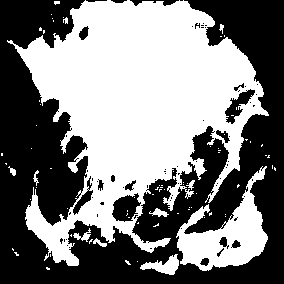

In [42]:
augmentationsresult = mask_to_image(mask[1])
result

In [1]:
# get input data and true masks
images, true_masks, _ = next(test_iterator)
# convert images to tensors
images_in = images.astype(np.float64)
true_masks = true_masks.astype(np.float64)
images_in = torch.Tensor(images_in)
true_masks = torch.Tensor(true_masks)
images_in = torch.permute(images_in,(0,3,1,2))
assert images_in.shape[1] == net.n_channels, \
    f'Network has been defined with {net.n_channels} input channels, ' \
    f'but loaded images have {images.shape[1]} channels. Please check that ' \
    'the images are loaded correctly.'
images_in = images_in.to(device=device, dtype=torch.float32)/255
true_masks_in = true_masks.to(device=device, dtype=torch.long)

pred_masks = net(images_in)
loss = criterion(pred_masks, true_masks_in) \
                               + dice_loss(F.softmax(pred_masks, dim=1).float(),
                                           F.one_hot(true_masks_in, net.n_classes).permute(0, 3, 1, 2).float())

pred_masks = pred_masks.detach().cpu()
pred_masks = torch.sigmoid(pred_masks)

x = torch.argmax(pred_masks, dim=1)
print(torch.unique(x))

pred_masks[pred_masks >= 0.5] = 1
pred_masks[pred_masks < 0.5] = 0

pred_masks = pred_masks.numpy().astype(np.uint8)

plt.imshow(images[0,:,:,:])
plt.xticks([], [])
plt.yticks([], [])
plt.show()

del images_in
del true_masks_in
del pred_masks
del loss
torch.cuda.empty_cache()

NameError: name 'test_iterator' is not defined

In [ ]:
fig, axes = plt.subplots(1, 2)
for i in range(2):
    axes[i].imshow(true_masks[0,:,:,i], cmap='gray', vmax=1, vmin=0)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()

fig, axes = plt.subplots(1, 2)
for i in range(2):
    axes[i].imshow(pred_masks[0,i,:,:], cmap='gray', vmax=1, vmin=0)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()